<a href="https://colab.research.google.com/github/Palaeoprot/IPA/blob/main/AAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
#@title  Packages and Globlal Variables
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
import gspread
import random
#from scipy.optimize import curve_fit
#from scipy.optimize import differential_evolution
#from scipy.interpolate import interp1d


# Precomputed activation energies in kJ/mol (converted to J/mol)
activation_energies = {
    'Asx_ConcTHAA': 111.09 * 1000,
    'Asx_ConcFAA': 98.93 * 1000, 'Asx_DLTHAA': 126.02 * 1000, 'Asx_DLFAA': 121.99 * 1000, 'Glx_ConcTHAA': 105.46 * 1000, 'Glx_ConcFAA': 109.39 * 1000, 'Glx_DLTHAA': 121.89 * 1000,
    'Glx_DLFAA': 100.80 * 1000, 'Ser_ConcTHAA': 127.59 * 1000, 'Ser_ConcFAA': 97.95 * 1000, 'Ser_DLTHAA': 123.03 * 1000, 'Ser_DLFAA': 116.72 * 1000, 'Ala_ConcTHAA': 96.58 * 1000,
    'Ala_ConcFAA': 112.12 * 1000, 'Ala_DLTHAA': 113.58 * 1000, 'Ala_DLFAA': 98.88 * 1000, 'Val_ConcTHAA': 111.00 * 1000, 'Val_ConcFAA': 122.81 * 1000,
    'Val_DLTHAA': 99.73 * 1000, 'Val_DLFAA': 128.52 * 1000, 'Phe_ConcTHAA': 113.28 * 1000, 'Phe_ConcFAA': 98.88 * 1000, 'Phe_DLTHAA': 128.15 * 1000, 'Phe_DLFAA': 102.27 * 1000, 'Leu_ConcTHAA': 114.09 * 1000,
    'Leu_ConcFAA': 103.75 * 1000, 'Leu_DLTHAA': 105.43 * 1000, 'Leu_DLFAA': 105.43 * 1000, 'Ile_ConcTHAA': 114.09 * 1000, 'Ile_ConcFAA': 103.75 * 1000, 'Ile_DLTHAA': 105.43 * 1000, 'Ile_DLFAA': 105.43 * 1000
}

# Define the mapping from one-letter to three-letter amino acid codes
one_to_three_letter = {
    "I": "Ile", "V": "Val", "L": "Leu", "F": "Phe", "C": "Cys", "M": "Met",
    "A": "Ala", "G": "Gly", "T": "Thr", "W": "Trp", "S": "Ser", "Y": "Tyr",
    "P": "Pro", "H": "His", "Q": "Gln", "E": "Glx", "N": "Asn", "D": "Asx",
    "K": "Lys", "R": "Arg", "D": "Asx", "E": "Glx"
}

# Pre-exponential factors for each type of rate (example values)
pre_exponential_factors = {
    'Asx': {'internal': 1e19, 'terminal': 1e20, 'free': 1e18, 'loss': 1e18},
    'Glx': {'internal': 1e17, 'terminal': 1e20, 'free': 1e17, 'loss': 1e16},
    'Ser': {'internal': 1e19, 'terminal': 1e20, 'free': 1e20, 'loss': 1e15},
    'Ala': {'internal': 1e17, 'terminal': 1e17, 'free': 1e16, 'loss': 1e20},
    'Val': {'internal': 1e17, 'terminal': 1e20, 'free': 1e15, 'loss': 1e10},
    'Phe': {'internal': 1e17, 'terminal': 1e17, 'free': 1e20, 'loss': 1e15},
    'Leu': {'internal': 1e19, 'terminal': 1e18, 'free': 1e13, 'loss': 1e20},
    'Ile': {'internal': 1e16, 'terminal': 1e20, 'free': 1e18, 'loss': 1e20}
}

# Define a mapping from rate type descriptions to pre-exponential factor keys
rate_type_mapping = {
    'ConcTHAA': 'internal',
    'ConcFAA': 'terminal',
    'DLTHAA': 'free',
    'DLFAA': 'loss'
}

# Function to calculate the rate constant using the Arrhenius equation with pre-exponential
# Universal gas constant in J/(mol·K)
R = 8.314
def arrhenius_rate_constant(E_a, T, A):
    return A * np.exp(-E_a / (R * T))


In [187]:
#@title Colours
# Load color dictionary
color_dict_path = '/content/drive/MyDrive/Colab_Notebooks/Dictionaries/Colours/colors.json'
with open(color_dict_path, 'r') as file:
    color_dict = json.load(file)


# Amino acid colors
amino_acid_colors = color_dict["amino_acids_colors"]
one_to_three_letter = {'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys', 'E': 'Glu', 'Q': 'Gln', 'G': 'Gly', 'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys', 'M': 'Met', 'F': 'Phe', 'P': 'Pro', 'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'}
amino_acid_colors_three_letter = {one_to_three_letter[k]: v for k, v in amino_acid_colors.items() if k in one_to_three_letter}

# Function to adjust color saturation
def adjust_saturation(color, amount=0.5):
    color = mcolors.to_rgba(color)
    color = mcolors.rgb_to_hsv(color[:3])
    color[1] = max(0, min(1, color[1] * amount))
    return mcolors.hsv_to_rgb(color)

# Adjust colors for standard deviations
std_colors = {k: adjust_saturation(v, 0.5) for k, v in amino_acid_colors_three_letter.items()}

In [191]:
#@title Load Data
# URLs and GIDs for Google Sheets
sheet_id = "1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E"
gid = "1259514505"
export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
try:
  df = pd.read_csv(export_url)
  print("Data successfully loaded into DataFrame!")
except Exception as e:
  print(f"Error: Could not access data. {e}")

# Ensure the columns match your Google Sheets structure
expected_columns = [
    'Pre-heat bleach time (h)', 'temp (°C)', 'pH', 'sample', 'time (h)',
    '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]',
    'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L'
]

# Ensure all expected columns are present in the data
data = df[expected_columns]

# # Initial Data Check
# print("Initial Data:")
# print(data.head())

# Function to filter and clean data
def clean_data(df):
    # Convert concentration and D/L columns to numeric, coerce errors to NaN
    concentration_columns = ['[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]']
    dl_columns = ['Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L']

    for col in concentration_columns + dl_columns:
        df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

    # Filter out rows with comments or non-numeric entries in critical columns
    df = df.dropna(subset=concentration_columns + dl_columns)

    return df

cleaned_data = clean_data(data)

# Function to calculate means and standard deviations separately for FAA and THAA, including time
def calculate_stats(df):
    faa_df = df[df['sample'] == 'FAA']
    thaa_df = df[df['sample'] == 'THAA']

    grouped_faa = faa_df.groupby(['temp (°C)', 'time (h)']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    grouped_thaa = thaa_df.groupby(['temp (°C)', 'time (h)']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    # Rename columns to reflect FAA and THAA
    new_columns_faa = ['temp (°C)', 'time (h)'] + [f'{aa}_Conc_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                      [f'{aa}_D/L_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]
    new_columns_thaa = ['temp (°C)', 'time (h)'] + [f'{aa}_Conc_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                       [f'{aa}_D/L_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]

    grouped_faa.columns = new_columns_faa
    grouped_thaa.columns = new_columns_thaa

    # Handle single values and missing standard deviations
    for col in new_columns_faa:
        if '_Std' in col:
            grouped_faa[col] = grouped_faa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)
    for col in new_columns_thaa:
        if '_Std' in col:
            grouped_thaa[col] = grouped_thaa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)

    return grouped_faa, grouped_thaa

# Calculate statistics
faa_stats, thaa_stats = calculate_stats(cleaned_data)

# Merge FAA and THAA statistics
data_interpolated = pd.merge(faa_stats, thaa_stats, on=['temp (°C)', 'time (h)'], how='outer')

# Add 'temp (K)' column to the merged DataFrame
data_interpolated['temp (K)'] = data_interpolated['temp (°C)'] + 273.15

# Initial Data Check after Cleaning and Interpolation
print("Cleaned and Interpolated Data:")
print(data_interpolated.head())
headers=data_interpolated.columns.tolist()
print(headers)  # Original headers

Data successfully loaded into DataFrame!
Cleaned and Interpolated Data:
   temp (°C)  time (h) Asx_Conc_FAA_Mean  Asx_Conc_FAA_Std  \
0         80       0.0         43.333333          8.082904   
1         80      24.0             83.25         35.453021   
2         80      96.0             161.0          0.000000   
3         80      97.0         67.333333         15.044379   
4         80     120.0        171.714286         18.034359   

   Asx_Conc_FAA_Count Glx_Conc_FAA_Mean  Glx_Conc_FAA_Std  Glx_Conc_FAA_Count  \
0                 3.0         25.666667          5.033223                 3.0   
1                 4.0              52.0         21.400935                 4.0   
2                 1.0              95.0          0.000000                 1.0   
3                 3.0         40.333333          8.020806                 3.0   
4                 7.0        106.142857         17.218484                 7.0   

  Ser_Conc_FAA_Mean  Ser_Conc_FAA_Std  ...  Val_D/L_THAA_Mean  \
0  

In [ ]:
#Explore datafile
data_interpolated.head(3)

In [193]:
# Dummy data
Asx_data = {
    'temp (°C)': [110.00] * 10,
    'time (h)': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Asx_Conc_FAA_Mean': [0.03, 0.05, 0.13, 0.19, 0.24, 0.27, 0.25, 0.25, 0.27, 0.25],
    'Asx_Conc_FAA_Std': [0.02, 0.01, 0.01, 0.03, 0.03, 0.05, 0.01, 0.00, 0.00, 0.02],
    'Asx_D/L_FAA_Mean': [0.05, 0.42, 0.62, 0.75, 0.81, 0.84, 0.87, 0.88, 0.89, 0.90],
    'Asx_D/L_FAA_Std': [0.04, 0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.01, 0.00, 0.00],
    'Asx_Conc_THAA_Mean': [1.00, 0.87, 0.88, 0.88, 0.79, 0.74, 0.54, 0.63, 0.53, 0.55],
    'Asx_Conc_THAA_Std': [0.02, 0.10, 0.05, 0.10, 0.13, 0.17, 0.02, 0.12, 0.00, 0.08],
    'Asx_D/L_THAA_Mean': [0.12, 0.41, 0.62, 0.72, 0.78, 0.81, 0.85, 0.86, 0.82, 0.89],
    'Asx_D/L_THAA_Std': [0.00, 0.03, 0.04, 0.01, 0.02, 0.01, 0.00, 0.01, 0.00, 0.01]
}
dummy_data
val_data = {
  'temp (°C)': [110.00] * 10,  # Repeat 110.00 for 10 rows
  'time (h)': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
  'Val_Conc_FAA_Mean': [float(val.split()[0]) for val in val.splitlines()[2::2]],  # Extract means from even lines (starting from line 3)
  'Val_Conc_FAA_Std': [float(val.split()[1]) for val in val.splitlines()[2::2]],  # Extract stds from even lines
  'Val_D/L_FAA_Mean': [float(val.split()[0]) for val in val.splitlines()[3::2]],  # Extract means from odd lines
  'Val_D/L_FAA_Std': [float(val.split()[1]) for val in val.splitlines()[3::2]],  # Extract stds from odd lines
  'Val_Conc_THAA_Mean': [float(val.split()[0]) for val in val.splitlines()[6::2]],  # Extract means from even lines (starting from line 7)
  'Val_Conc_THAA_Std': [float(val.split()[1]) for val in val.splitlines()[6::2]],  # Extract stds from even lines
  'Val_D/L_THAA_Mean': [float(val.split()[0]) for val in val.splitlines()[7::2]],  # Extract means from odd lines
  'Val_D/L_THAA_Std': [float(val.split()[1]) for val in val.splitlines()[7::2]]   # Extract stds from odd lines
}

print(val_data)

dummy_df = pd.DataFrame(dummy_data)

# Fixed rate values for debugging
fixed_rate_hydrolysis = 0.02
fixed_rate_loss = 0.015
fixed_rate_internal = 0.4
fixed_rate_terminal = 0
fixed_rate_free = 0.1
fold_water = 1.2
# Calculate total initial concentration
total_initial_concentration = dummy_df['Asx_Conc_THAA_Mean'][0]

# Calculate total amount of water
total_water = total_initial_concentration * fold_water
#protein
initial_length = 1500  # Example initial protein length#@title  Function to simulate

# Slow pool parameters
slow_hydrolysis_pool_size = 0.5  # Range 0 -1
slow_hydrolysis_pool_relative_rate = 0.00001  # Hydrolysis  Range 0 -1 slower in the slow pool

# Slow DL terminal pool parameters
slow_DL_terminal_pool_size = 0 # Rage 0 - 1
slow_DL_terminal_pool_relative_rate = 0.000001  # DL terminal  Range 0 -1 slower in the slow pool

# Slow DL internal pool parametersx
slow_DL_internal_pool_size = 0.5  #Rage 0 - 1
slow_DL_internal_pool_relative_rate = 0.00000001  # DL internal  Range 0 -1 slower in the slow pool


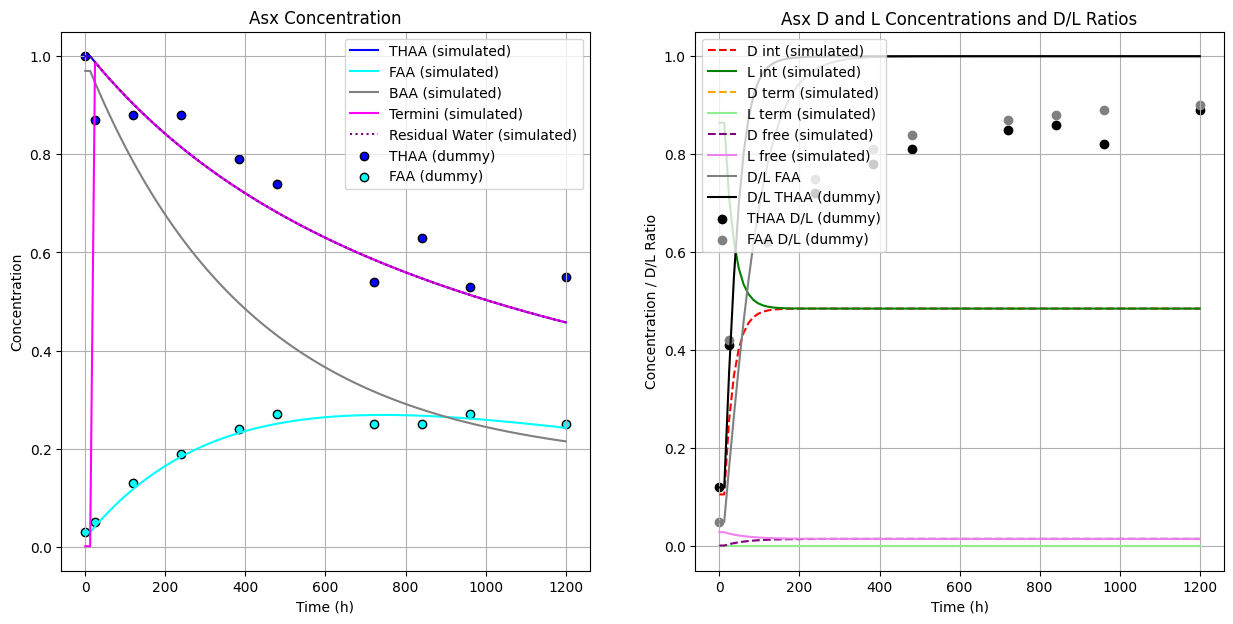

In [194]:
#@title  Function to simulate hydrolysis for a polymer chain
def solve_dl(ratio, sum_value):
    """
    This function calculates D and L given a ratio (D/L) and their sum.



    Args:
        ratio: The value of the D/L ratio (float).
        sum_value: The total concentration of D and L (float).

    Returns:
        A tuple containing the calculated values of D and L (float, float).
    """
    # Solve for D first
    L = sum_value / (1 + ratio)

    # Calculate L using the value of D
    D = ratio * L

    return D, L

def decay_polymer(initial_length, decay_rate, time):
    """
    Simulates deterministic hydrolysis for the polymer chain and tracks water molecules released.

    Args:
        initial_length: Initial length of the polymer chain.
        decay_rate: Rate of hydrolysis per unit time.
        time: Simulation time.

    Returns:
        average_length: Average length of the polymer chain after hydrolysis.
        hydrolyzed_units: Number of units hydrolyzed from the chain.
        end_units: Number of new end units created due to hydrolysis.
        water_released: Number of water molecules released due to decay processes.
    """
    # Calculate total number of hydrolysis events
    hydrolyzed_units = int(initial_length * time * decay_rate)

    # Ensure at least one unit remains after hydrolysis
    if hydrolyzed_units >= initial_length:
        hydrolyzed_units = initial_length - 1
        current_length = 1
    else:
        current_length = initial_length - hydrolyzed_units

    # Calculate end units based on hydrolyzed units
    end_units = hydrolyzed_units * 2

    # Calculate average length
    average_length = current_length / (initial_length - hydrolyzed_units)

    # Simulate water released due to decay (adjust this part based on specific amino acids like serine)
    water_released = 0  # Placeholder, update based on actual decay processes

    return average_length, hydrolyzed_units, end_units, water_released

def generate_simplified_data(dummy_data, initial_length, fold_water, slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate):
    max_time = dummy_data['time (h)'].max()
    num_time_points = 100
    time_points = np.linspace(0, max_time, num_time_points)

    data = {
        'time (h)': [], 'Asx_THAA': [], 'Asx_FAA': [], 'Asx_BAA': [],
        'Termini': [], 'N_Termini': [], 'Residual_water': [],
        'Asx_D_int': [], 'Asx_L_int': [], 'Asx_D_term': [], 'Asx_L_term': [],
        'Asx_D_free': [], 'Asx_L_free': [],
        'Water_used_hydrolysis': [], 'Water_generated_decomposition': [],
        'slow_hydrolysis_pool_size': [], 'slow_hydrolysis_pool_relative_rate': [],
        'slow_DL_terminal_pool_size': [], 'slow_DL_terminal_pool_relative_rate': [],
        'slow_DL_internal_pool_size': [], 'slow_DL_internal_pool_relative_rate': []
    }

    initial_Asx_THAA = dummy_data.loc[0, 'Asx_Conc_THAA_Mean']
    total_water = initial_Asx_THAA * fold_water
    residual_water = total_water

    THAA = dummy_data.loc[0, 'Asx_Conc_THAA_Mean']
    FAA = dummy_data.loc[0, 'Asx_Conc_FAA_Mean']
    DL_THAA = dummy_data.loc[0, 'Asx_D/L_THAA_Mean']
    DL_FAA = dummy_data.loc[0, 'Asx_D/L_FAA_Mean']

    D_total, L_total = solve_dl(DL_THAA, THAA)
    D_free, L_free = solve_dl(DL_FAA, FAA)
    BAA = THAA - FAA
    DL_BAA = (D_total - D_free) / (L_total - L_free)
    termini = (BAA / initial_length) * 2
    N_termini = BAA / initial_length
    D_BAA = D_total - D_free
    L_BAA = L_total - L_free
    D_term = 0
    L_term = 0
    D_int = D_BAA
    L_int = L_BAA

    water_used_hydrolysis = 0
    water_generated_decomposition = 0

    # Create a dictionary to store all variables
    variables = {
        'Asx_THAA': THAA, 'Asx_FAA': FAA, 'Asx_BAA': BAA,
        'Termini': termini, 'N_Termini': N_termini, 'Residual_water': residual_water,
        'Asx_D_int': D_int, 'Asx_L_int': L_int, 'Asx_D_term': D_term, 'Asx_L_term': L_term,
        'Asx_D_free': D_free, 'Asx_L_free': L_free,
        'Water_used_hydrolysis': water_used_hydrolysis, 'Water_generated_decomposition': water_generated_decomposition,
        'slow_hydrolysis_pool_size': slow_hydrolysis_pool_size, 'slow_hydrolysis_pool_relative_rate': slow_hydrolysis_pool_relative_rate,
        'slow_DL_terminal_pool_size': slow_DL_terminal_pool_size, 'slow_DL_terminal_pool_relative_rate': slow_DL_terminal_pool_relative_rate,
        'slow_DL_internal_pool_size': slow_DL_internal_pool_size, 'slow_DL_internal_pool_relative_rate': slow_DL_internal_pool_relative_rate
    }

    for time in time_points:
        # Append current values to data lists
        for key in data.keys():
            if key == 'time (h)':
                data[key].append(time)
            else:
                data[key].append(variables[key])

        if time > 0:
            # Calculate hydrolysis rate based on fold_water and slow pool parameters
            fast_hydrolysis_pool_size = 1 - slow_hydrolysis_pool_size
            hydrolysis_rate_fast = fixed_rate_hydrolysis * fold_water
            hydrolysis_rate_slow = hydrolysis_rate_fast * slow_hydrolysis_pool_relative_rate
            hydrolysis_rate = (hydrolysis_rate_fast * fast_hydrolysis_pool_size + hydrolysis_rate_slow * slow_hydrolysis_pool_size) * (variables['Residual_water'] / total_water)

            # Update THAA, FAA, and BAA
            THAA_hydrolyzed = hydrolysis_rate * variables['Asx_THAA']
            variables['Asx_THAA'] = max(variables['Asx_THAA'] - THAA_hydrolyzed, 0)
            variables['Asx_FAA'] = min(max(variables['Asx_FAA'] + THAA_hydrolyzed - fixed_rate_loss * variables['Asx_FAA'], 0), variables['Asx_THAA'])
            variables['Asx_BAA'] = variables['Asx_THAA'] - variables['Asx_FAA']

            # Update water
            total_water = initial_Asx_THAA * fold_water
            water_used = THAA_hydrolyzed * fold_water
            variables['Water_used_hydrolysis'] += water_used
            variables['Residual_water'] = max(variables['Residual_water'] - water_used, 0)

            # Update D/L ratios
            variables['Asx_D_int'], variables['Asx_L_int'] = update_dl_ratio(variables['Asx_D_int'], variables['Asx_L_int'], fixed_rate_internal, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate)
            variables['Asx_D_term'], variables['Asx_L_term'] = update_dl_ratio(variables['Asx_D_term'], variables['Asx_L_term'], fixed_rate_terminal, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate)
            variables['Asx_D_free'], variables['Asx_L_free'] = update_dl_ratio(variables['Asx_D_free'], variables['Asx_L_free'], fixed_rate_free, 0, 1) # Assuming no slow pool for free AA

            # Update termini
            avg_length, hydrolyzed_units, end_units, water_released = decay_polymer(initial_length, hydrolysis_rate, time)
            variables['Termini'] = min(end_units, (variables['Asx_THAA'] * initial_length) / initial_length)
            variables['N_Termini'] = variables['Asx_BAA'] / initial_length

            variables['Water_generated_decomposition'] += water_released

    return pd.DataFrame(data)

def update_dl_ratio(D, L, rate, slow_pool_size, slow_pool_relative_rate):
    fast_pool_size = 1 - slow_pool_size
    rate_fast = rate
    rate_slow = rate * slow_pool_relative_rate
    effective_rate = rate_fast * fast_pool_size + rate_slow * slow_pool_size
    D_new = D + (L * effective_rate) - (D * effective_rate)
    L_new = L - (L * effective_rate) + (D * effective_rate)
    return D_new, L_new

# Generate simplified data
simplified_data = generate_simplified_data(dummy_df, initial_length, fold_water, slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate)

# Plot the simplified data with dummy data
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)


# Plot concentrations
axs[0].plot(simplified_data['time (h)'], simplified_data['Asx_THAA'], label='THAA (simulated)', color='blue')
axs[0].plot(simplified_data['time (h)'], simplified_data['Asx_FAA'], label='FAA (simulated)', color='cyan')
axs[0].plot(simplified_data['time (h)'], simplified_data['Asx_BAA'], label='BAA (simulated)', color='gray')
axs[0].plot(simplified_data['time (h)'], simplified_data['Termini'], label='Termini (simulated)', color='magenta')
#axs[0].plot(simplified_data['time (h)'], simplified_data['N_Termini'], label='N Termini (simulated)', color='orange')
axs[0].plot(simplified_data['time (h)'],  simplified_data['Residual_water'] / (dummy_df['Asx_Conc_THAA_Mean'][0] * fold_water),
            label='Residual Water (simulated)',
            linestyle=':',
            color='purple')
#axs[0].plot(simplified_data['time (h)'], simplified_data['Residual_water'] / dummy_df['Asx_Conc_THAA_Mean'][0], label='Residual Water (simulated)', linestyle=':', color='purple')
#axs[0].plot(simplified_data['time (h)'], simplified_data['Residual_water'] / (fold_water/dummy_df['Asx_Conc_THAA_Mean'][0]), label='Residual Water (simulated)', linestyle=':', color='purple')
axs[0].scatter(dummy_df['time (h)'], dummy_df['Asx_Conc_THAA_Mean'], label='THAA (dummy)', color='blue', edgecolor='black')
axs[0].scatter(dummy_df['time (h)'], dummy_df['Asx_Conc_FAA_Mean'], label='FAA (dummy)', color='cyan', edgecolor='black')
axs[0].set_xlabel('Time (h)')
axs[0].set_ylabel('Concentration')
axs[0].set_title('Asx Concentration')
axs[0].legend()
axs[0].grid(True)

# Plot D/L ratios
axs[1].plot(simplified_data['time (h)'], simplified_data['Asx_D_int'], label='D int (simulated)', linestyle='--', color='red')
axs[1].plot(simplified_data['time (h)'], simplified_data['Asx_L_int'], label='L int (simulated)', linestyle='-', color='green')
axs[1].plot(simplified_data['time (h)'], simplified_data['Asx_D_term'], label='D term (simulated)', linestyle='--', color='orange')
axs[1].plot(simplified_data['time (h)'], simplified_data['Asx_L_term'], label='L term (simulated)', linestyle='-', color='lightgreen')
axs[1].plot(simplified_data['time (h)'], simplified_data['Asx_D_free'], label='D free (simulated)', linestyle='--', color='purple')
axs[1].plot(simplified_data['time (h)'], simplified_data['Asx_L_free'], label='L free (simulated)', linestyle='-', color='violet')
axs[1].plot(simplified_data['time (h)'], (simplified_data['Asx_D_free']/simplified_data['Asx_L_free']), label='D/L FAA ', linestyle='-', color='gray')
axs[1].plot(simplified_data['time (h)'], (simplified_data['Asx_D_free']+ simplified_data['Asx_D_term']+ simplified_data['Asx_D_int'])/(simplified_data['Asx_L_free'] + simplified_data['Asx_L_term'] + simplified_data['Asx_L_int']), label='D/L THAA (dummy)', color='black')
axs[1].scatter(dummy_df['time (h)'], dummy_df['Asx_D/L_THAA_Mean'], label='THAA D/L (dummy)', color='black', edgecolor='black')
axs[1].scatter(dummy_df['time (h)'], dummy_df['Asx_D/L_FAA_Mean'], label='FAA D/L (dummy)', color='grey', edgecolor='grey')
axs[1].set_xlabel('Time (h)')
axs[1].set_ylabel('Concentration / D/L Ratio')
axs[1].set_title('Asx D and L Concentrations and D/L Ratios')
axs[1].legend()
axs[1].grid(True)

plt.show()

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np
import pandas as pd

# Your existing dummy_data and dummy_df setup here

def objective_function(params):
    # Unpack parameters
    fixed_rate_internal, fixed_rate_terminal, fixed_rate_free, fold_water, slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate = params

    # Set fixed parameters
    fixed_rate_hydrolysis = 0.02  # You might want to optimize this too
    fixed_rate_loss = 0.015  # You might want to optimize this too
    initial_length = 1500  # You might want to optimize this too

    # Run your model with these parameters
    model_results = generate_simplified_data(
        dummy_df, initial_length, fold_water,
        slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate,
        slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate,
        slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate
    )

    # Calculate THAA_DL and FAA_DL from model results
    model_THAA_DL = (model_results['Asx_D_free'] + model_results['Asx_D_term'] + model_results['Asx_D_int']) / (model_results['Asx_L_free'] + model_results['Asx_L_term'] + model_results['Asx_L_int'])
    model_FAA_DL = model_results['Asx_D_free'] / model_results['Asx_L_free']

    # Calculate error between model and observed data
    error_THAA_DL = np.sum((model_THAA_DL - dummy_df['Asx_D/L_THAA_Mean'])**2)
    error_FAA_DL = np.sum((model_FAA_DL - dummy_df['Asx_D/L_FAA_Mean'])**2)

    return error_THAA_DL + error_FAA_DL

# Define bounds for each parameter
bounds = [
    (0, 1),  # fixed_rate_internal
    (0, 1),  # fixed_rate_terminal
    (0, 1),  # fixed_rate_free
    (1, 10),  # fold_water
    (0, 1),  # slow_hydrolysis_pool_size
    (0, 0.001),  # slow_hydrolysis_pool_relative_rate
    (0, 1),  # slow_DL_terminal_pool_size
    (0, 0.001),  # slow_DL_terminal_pool_relative_rate
    (0, 1),  # slow_DL_internal_pool_size
    (0, 0.001)  # slow_DL_internal_pool_relative_rate
]

# Run optimization
result = differential_evolution(objective_function, bounds, popsize=20, mutation=(0.5, 1), recombination=0.7)

# Print optimized parameters
print("Optimized parameters:")
param_names = ['fixed_rate_internal', 'fixed_rate_terminal', 'fixed_rate_free', 'fold_water',
               'slow_hydrolysis_pool_size', 'slow_hydrolysis_pool_relative_rate',
               'slow_DL_terminal_pool_size', 'slow_DL_terminal_pool_relative_rate',
               'slow_DL_internal_pool_size', 'slow_DL_internal_pool_relative_rate']
for name, value in zip(param_names, result.x):
    print(f"{name}: {value}")

print(f"Final error: {result.fun}")

In [ ]:
data_interpolated.head(60)

In [ ]:
#@title Optimisation - slow - takes about 10 minutes
def arrhenius_scale_factor(T1, T2, Ea):
    """Calculate the Arrhenius scale factor between two temperatures."""
    return np.exp((Ea / R) * (1 / T1 - 1 / T2))

def scale_time(time, scale_factor):
    """Scale the time array by a given factor."""
    return time * scale_factor

def interpolate_data(time, data, new_time):
    """Interpolate data to new time points."""
    f = interp1d(time, data, kind='linear', fill_value='extrapolate')
    return f(new_time)

def calculate_rmse(original, scaled):
    """Calculate the Root Mean Square Error between original and scaled times."""
    return np.sqrt(np.mean((original - scaled) ** 2))

def objective_function(Ea, times, temperatures, values):
    """
    Objective function to minimize for finding the best scaling factor.
    This function calculates the total RMSE between scaled data points.
    """
    reference_temp = temperatures[0]
    reference_time = times[0]
    reference_values = values[0]

    # Create a common time scale
    all_times = np.concatenate(times)
    common_time = np.linspace(all_times.min(), all_times.max(), num=1000)

    total_rmse = 0
    for i in range(1, len(temperatures)):
        scale_factor = arrhenius_scale_factor(temperatures[i], reference_temp, Ea)
        scaled_time = scale_time(times[i], 1 / scale_factor)  # Inverse scaling to align with reference

        # Interpolate both reference and scaled data to the common time scale
        reference_interp = interpolate_data(reference_time, reference_values, common_time)
        scaled_interp = interpolate_data(scaled_time, values[i], common_time)

        # Calculate RMSE between interpolated reference and scaled data
        total_rmse += calculate_rmse(reference_interp, scaled_interp)

    return total_rmse

def optimize_activation_energy(times, temperatures, values):
    """Optimize the activation energy using differential evolution."""
    bounds = [(95, 130)]  # Reasonable bounds for Ea in kJ/mol
    result = differential_evolution(
        objective_function,
        bounds,
        args=(times, temperatures, values),
        popsize=20,
        mutation=(0.5, 1),
        recombination=0.7,
        updating='deferred',
        workers=-1
    )
    return result.x[0]

def process_amino_acid(data, amino_acid, measurement_type):
    """Process data for a single amino acid and measurement type."""
    temp_columns = data['temp (K)'].unique()
    times = [data[data['temp (K)'] == temp]['time (h)'].values for temp in temp_columns]

    column_name = f"{amino_acid}{measurement_type}_Mean"
    values = [data[data['temp (K)'] == temp][column_name].values for temp in temp_columns]

    optimized_Ea = optimize_activation_energy(times, temp_columns, values)

    reference_temp = temp_columns[0]
    scale_factors = [arrhenius_scale_factor(temp, reference_temp, optimized_Ea) for temp in temp_columns]

    scaled_times = [scale_time(time, 1 / sf) for time, sf in zip(times, scale_factors)]

    return optimized_Ea, scaled_times, values

def main_ml(data):
    amino_acids = ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile']
    measurement_types = ['ConcTHAA', 'ConcFAA', 'D/LTHAA', 'D/LFAA']

    results = {}
    for aa in amino_acids:
        for mt in measurement_types:
            key = f"{aa}_{mt}"
            model, scaled_times, values = process_amino_acid_ml(data, aa, mt)
            results[key] = {
                'model': model,
                'scaled_times': scaled_times,
                'values': values
            }

    return results

def plot_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    color = amino_acid_colors_three_letter.get(amino_acid, '#000000')

    for i, aa in enumerate(['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile']):
        color = colors[i]

        # Concentration plot
        for mt, style in zip(['ConcTHAA', 'ConcFAA'], ['-', '--']):
            key = f"{aa}_{mt}"
            scaled_times, values = results[key][1], results[key][2]
            for st, v in zip(scaled_times, values):
                ax1.plot(st, v, color=color, linestyle=style, alpha=0.7)

        # D/L ratio plot
        for mt, style in zip(['D/LTHAA', 'D/LFAA'], ['-', '--']):
            key = f"{aa}_{mt}"
            scaled_times, values = results[key][1], results[key][2]
            for st, v in zip(scaled_times, values):
                ax2.plot(st, v, color=color, linestyle=style, alpha=0.7, label=f"{aa} {mt}")

    ax1.set_xlabel('Scaled Time')
    ax1.set_ylabel('Concentration')
    ax1.set_title('Scaled Time vs Concentration for All Amino Acids (FAA and THAA)')

    ax2.set_xlabel('Scaled Time')
    ax2.set_ylabel('D/L Ratio')
    ax2.set_title('Scaled Time vs D/L Ratio for All Amino Acids (FAA and THAA)')

    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

# Example usage
results = main(data_interpolated)
# Print activation energies in kJ/mol
for key, result in results.items(): # Iterate over the dictionary values instead
    Ea = result['Ea'] # Extract the activation energy from the result dictionary
    print(f"Activation Energy for {key}: {Ea:.2f} kJ/mol")

Activation Energy for Asx_ConcTHAA: 111.09 kJ/mol
Activation Energy for Asx_ConcFAA: 98.93 kJ/mol
Activation Energy for Asx_D/LTHAA: 126.02 kJ/mol
Activation Energy for Asx_D/LFAA: 121.99 kJ/mol
Activation Energy for Glx_ConcTHAA: 105.46 kJ/mol
Activation Energy for Glx_ConcFAA: 109.39 kJ/mol
Activation Energy for Glx_D/LTHAA: 121.89 kJ/mol
Activation Energy for Glx_D/LFAA: 100.80 kJ/mol
Activation Energy for Ser_ConcTHAA: 127.59 kJ/mol
Activation Energy for Ser_ConcFAA: 97.95 kJ/mol
Activation Energy for Ser_D/LTHAA: 123.03 kJ/mol
Activation Energy for Ser_D/LFAA: 116.72 kJ/mol
Activation Energy for Ala_ConcTHAA: 96.58 kJ/mol
Activation Energy for Ala_ConcFAA: 112.12 kJ/mol
Activation Energy for Ala_D/LTHAA: 113.58 kJ/mol
Activation Energy for Ala_D/LFAA: 98.88 kJ/mol
Activation Energy for Val_ConcTHAA: 111.00 kJ/mol
Activation Energy for Val_ConcFAA: 122.81 kJ/mol
Activation Energy for Val_D/LTHAA: 99.73 kJ/mol
Activation Energy for Val_D/LFAA: 128.52 kJ/mol
Activation Energy for Phe